In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

### Reads the data into a dataframe and renames the columns to remove unnecessary numbers 

In [2]:
data_df = pd.read_excel("RNASeqData.xlsx")

In [3]:
data_df = data_df.rename(columns=lambda x: re.sub("w_[0-9]+_O", "w_O",x))
data_df = data_df.rename(columns=lambda x: re.sub("m_[0-9]+_O", "m_O",x))

In [4]:
columns = list(data_df.columns) 

In [5]:
norm_cols = [x for x in columns if "Norm" in x] # get all normalized values
healthy_control = [x for x in norm_cols if "HC" in x] # healthy control norm values
norm_cols_base = [x for x in norm_cols if "Base" in x] # cf without treatment
norm_cols_v2 = [x for x in norm_cols if "V2" in x] # cf with treatment



### Remove extra characters so we can keep patient identifiers

In [6]:
df_norm_base = data_df[norm_cols_base]
df_norm_base = df_norm_base.rename(columns=lambda x: re.sub("Norm_Orkambi_0", "",x))
df_norm_base = df_norm_base.rename(columns=lambda x: re.sub("_Base", "",x))
df_norm_base = df_norm_base.sort_index(axis=1)
df_norm_base = df_norm_base.drop(columns=['02'])

df_norm_v2 = data_df[norm_cols_v2]
df_norm_v2 = df_norm_v2.rename(columns=lambda x: re.sub("Norm_Orkambi_0", "",x))
df_norm_v2 = df_norm_v2.rename(columns=lambda x: re.sub("_V2", "",x))
df_norm_v2 = df_norm_v2.sort_index(axis=1)
df_norm_v2 = df_norm_v2.drop(columns=['19'])

### Function: get_mean_diff
The function takes to lists and simply subtracts the corresponding values and finally takes the average of the differences.

Making a function call can take extra time, so for simple operations like these, it may be helpful when used in conjunction with the **map()** function.

In [7]:
from statistics import mean
def get_mean_diff(base, v2):
  diff = [base[i] - v2[i] for i in range(len(base))] 
  mean_diff = mean(diff)
  # mean of the vector 
  return mean_diff

### Function: get_avg_diff_count

In [53]:
import random
from random import randrange
from random import shuffle
def get_avg_diff_count(expvalues):
    num_shuffles=1000000
    base_copy = expvalues[0]
    v2_copy = expvalues[1]
    n_samples = len(base_copy)
    #observed_avg_diff = get_mean_diff(base_copy, v2_copy)
    obsdiff = [base_copy[i] - v2_copy[i] for i in range(n_samples)]
    observed_avg_diff = mean(obsdiff)
    count = 0
    #avg_diffs = []
    # try looping over shuffles
    randomorder = np.array(random.choices([1,-1], k=n_samples*num_shuffles))
    randomshape = (num_shuffles, n_samples)
    randomorder = randomorder.reshape(randomshape)
    randomdiff = np.multiply(randomorder, obsdiff)
    avg_diffs = np.average(randomdiff, axis=1)

    count=[]
    if (observed_avg_diff < 0):
        count = np.count_nonzero(avg_diffs < observed_avg_diff)
    elif (observed_avg_diff > 0):
        count = np.count_nonzero(avg_diffs > observed_avg_diff)
        
  
#    return count/num_shuffles, np.asarray(avg_diffs)
    return count/num_shuffles


### Function: avg_diff_sig_test

In [22]:
def avg_diff_sig_test(df_norm_base, df_norm_v2):
    fullzip = list(zip(df_norm_base.values, df_norm_v2.values))
    all_p_sig_values = [get_avg_diff_count(fullzip[i]) for i in range(len(fullzip))]
    #all_p_sig_values = map(get_avg_diff_count, fullzip)
    return list(all_p_sig_values)

In [23]:
df_norm_v2.shape

(15570, 19)

In [54]:
norm_p_values = avg_diff_sig_test(df_norm_base, df_norm_v2)

In [76]:
norm_p_values[0:5]

[0.140237, 0.145074, 0.004809, 0.323272, 0.051686]

In [36]:
#draw histogram

def draw_hist(d, observed):
    print(observed)
    hist,bin_edges = np.histogram(d,bins =70)    
    plt.figure(figsize=[8,8])
    plt.bar(bin_edges[:-1], hist, width = 0.1, color='#0504aa',alpha=0.7)
    #plt.xlim(min(min(bin_edges),-4), max(max(bin_edges),4))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title('Normal Distribution Histogram',fontsize=15)
    plt.axvline(x=observed, color='r', linestyle='dashed', linewidth=2)
    plt.show()

In [56]:
import pickle
pickle.dump( norm_p_values, open( "norm_p_values.p", "wb" ) )

**Bonferroni correction**

In this method, we divide the threshold by the number of genes. So, if we take a default threshold of 5% (or 0.05), now our threshold would be `0.05/len(norm_p_values)`

In [57]:
import pickle
norm_p_values = pickle.load( open( "norm_p_values.p", "rb" ) )
count_significant_genes_bonferroni = 0
for i, ele in enumerate(norm_p_values):
  if ele < (0.05/len(norm_p_values)):
    count_significant_genes_bonferroni += 1
    print(i+1)
print("Number of significant genes: ", count_significant_genes_bonferroni)

Number of significant genes:  0


**Benjamini–Hochberg procedure**

 Put the individual P values in order, from smallest to largest. The smallest P value has a rank of i=1, then next smallest has i=2, etc. Compare each individual P value to its Benjamini-Hochberg critical value, (i/m)Q, where i is the rank, m is the total number of tests, and Q is the false discovery rate you choose. The largest P value that has P<(i/m)Q is significant, and all of the P values smaller than it are also significant, even the ones that aren't less than their Benjamini-Hochberg critical value.

In [28]:
def benjamin_hochberg_corrected_p_values(p_values, fdr):
  num_genes = len(p_values)
  import numpy as np
  sorted_indices = np.argsort(p_values)
  sorted_p_values = sorted(p_values)
  benjamini_hochberg_critical_values = [((i+1)/num_genes)*fdr for i in range(num_genes)]
  for i, p_value in reversed(list(enumerate(sorted_p_values))):
    if p_value < benjamini_hochberg_critical_values[i]:
      break
  return i, sorted_indices

In [74]:
import pickle
norm_p_values = pickle.load( open( "norm_p_values.p", "rb" ) )
i, sorted_indices = benjamin_hochberg_corrected_p_values(norm_p_values, 0.25)
print("Number of significant genes: ", i+1)

Number of significant genes:  3231


In [59]:
significant_genes = []
for i in range(16):
  significant_genes.append((sorted_indices[i]+1))


significant_genes

[188,
 1095,
 13503,
 5750,
 1549,
 10516,
 11160,
 10363,
 1392,
 7868,
 7204,
 3290,
 8384,
 15332,
 10593,
 361]

In [31]:
print(data_df.loc[data_df['RowID'].isin(significant_genes)][['RowID', 'ID', 'Description']])

       RowID            ID                                        Description
187      188        ADAM22                    ADAM metallopeptidase domain 22
1094    1095          BCO2                          beta-carotene oxygenase 2
1548    1549      CACNA2D2  calcium voltage-gated channel auxiliary subuni...
2670    2671        CUEDC2                            CUE domain containing 2
3077    3078        DNASE1                                deoxyribonuclease I
5749    5750         KITLG                                         KIT ligand
7203    7204  LOC105378698                                                NaN
7867    7868        LRRC8D   leucine-rich repeat containing 8 family member D
10362  10363         PRDX1                                    peroxiredoxin 1
10515  10516         PSMD1               proteasome 26S subunit, non-ATPase 1
10592  10593        PTP4A2    protein tyrosine phosphatase type IVA, member 2
11159  11160        RNF165                            ring finge

In [ ]:
data_df[norm_cols_v2].sum(axis=0)

Norm_Orkambi_007_V2    2.201250e+07
Norm_Orkambi_009_V2    2.599588e+07
Norm_Orkambi_010_V2    2.801257e+07
Norm_Orkambi_012_V2    2.576081e+07
Norm_Orkambi_013_V2    2.615355e+07
Norm_Orkambi_014_V2    2.786734e+07
Norm_Orkambi_001_V2    3.455492e+07
Norm_Orkambi_004_V2    3.376038e+07
Norm_Orkambi_006_V2    2.666307e+07
Norm_Orkambi_015_V2    2.896782e+07
Norm_Orkambi_016_V2    2.332386e+07
Norm_Orkambi_017_V2    2.449434e+07
Norm_Orkambi_018_V2    2.312316e+07
Norm_Orkambi_019_V2    2.542411e+07
Norm_Orkambi_020_V2    2.495638e+07
Norm_Orkambi_021_V2    2.707834e+07
Norm_Orkambi_022_V2    2.569940e+07
Norm_Orkambi_024_V2    2.229553e+07
Norm_Orkambi_025_V2    3.108347e+07
Norm_Orkambi_026_V2    2.474027e+07
dtype: float64

In [63]:
a = ([1,2], [3,4], [5,6])
b = ([10,11], [12,13], [14,15])

x = zip(a, b)
x = list(x)
#use the tuple() function to display a readable version of the result:

#print(x[0])

[x[j] for j in range(len(x))]
exptest, exptest2 = x[0]
print(exptest)
print(exptest2)

[exptest[i] - exptest2[i] for i in range(len(exptest))]

#print(diff)


[1, 2]
[10, 11]


[-9, -9]

In [83]:
random.choices([1,-1], k=len(exptest))

[1, -1]

0.05


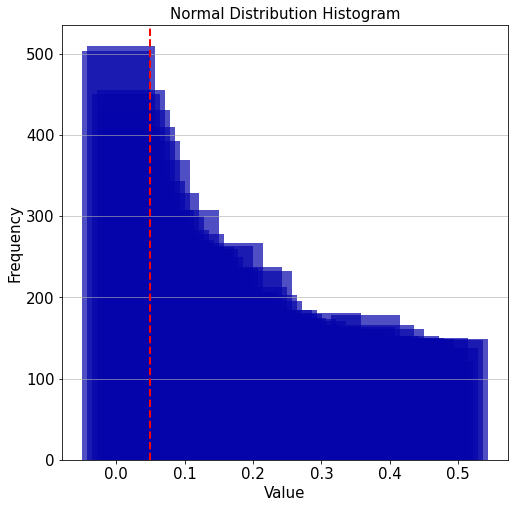

In [75]:
draw_hist(norm_p_values, 0.05)

In [60]:
tmp_sorted_indices = np.argsort(norm_p_values)

In [61]:
tmp_sorted_indices[:5]

array([  187,  1094, 13502,  5749,  1548], dtype=int64)

In [62]:
tmp_sorted_p_values = sorted(norm_p_values)

In [63]:
tmp_sorted_p_values[:50]

[1.1e-05,
 6e-05,
 0.000107,
 0.000113,
 0.000121,
 0.000123,
 0.000151,
 0.000179,
 0.000188,
 0.000189,
 0.000203,
 0.000205,
 0.000218,
 0.000227,
 0.00023,
 0.000233,
 0.00027,
 0.000289,
 0.000305,
 0.000349,
 0.000352,
 0.000352,
 0.000392,
 0.000416,
 0.000429,
 0.000443,
 0.000458,
 0.000459,
 0.000472,
 0.000483,
 0.000493,
 0.000504,
 0.000513,
 0.000531,
 0.000543,
 0.000547,
 0.000548,
 0.000549,
 0.00064,
 0.000644,
 0.000658,
 0.0007,
 0.000709,
 0.000732,
 0.000781,
 0.000799,
 0.000801,
 0.000834,
 0.000876,
 0.000941]

In [67]:
tmp_critical_values = [((i+1)/15000)*0.1 for i in range(15000)]

In [68]:
tmp_critical_values[:10]

[6.6666666666666675e-06,
 1.3333333333333335e-05,
 2e-05,
 2.666666666666667e-05,
 3.3333333333333335e-05,
 4e-05,
 4.666666666666667e-05,
 5.333333333333334e-05,
 5.9999999999999995e-05,
 6.666666666666667e-05]

### Akternative method
story 
https://puolival.github.io/multipy/
